## 研究和回测框架

In [1]:
import time
import calendar
import xlrd
import itertools
import copy
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pylab as plt
import warnings

from jqdata import *
from jqfactor import *
from datetime import datetime,timedelta
from tqdm import tqdm_notebook
from sklearn import preprocessing
from scipy.stats import pearsonr, boxcox, ttest_1samp
from scipy.stats.mstats import winsorize

warnings.filterwarnings("ignore")


# ----------------------------- 回测分析类 ---------------------------------------
class ParameterAnalysis(object):
    # 定义函数中不同的变量
    def __init__(self, algorithm_id=None):
        self.algorithm_id = algorithm_id            # 回测id
        self.params_df = pd.DataFrame()             # 回测中所有调参备选值的内容，列名字为对应修改面两名称，对应回测中的 g.XXXX
        self.results = {}                           # 回测结果的回报率，key 为 params_df 的行序号，value 为
        self.evaluations = {}                       # 回测结果的各项指标，key 为 params_df 的行序号，value 为一个 dataframe
        self.backtest_ids = {}                      # 回测结果的 id
        self.benchmark = ""                         # 新加入的基准的回测结果 id，可以默认为空 ''，则使用回测中设定的基准
        self.benchmark_returns = []                 # 新加入的基准的回测回报率
        self.returns = {}                           # 记录所有回报率
        self.excess_returns = {}                    # 记录超额收益率
        self.log_returns = {}                       # 记录收益率的 log 值
        self.log_excess_returns = {}                # 记录超额收益的 log 值
        self.dates = []                             # 回测对应的所有日期
        self.excess_max_drawdown = {}               # 计算超额收益的最大回撤
        self.excess_annual_return = {}              # 计算超额收益率的年化指标
        self.evaluations_df = pd.DataFrame()        # 记录各项回测指标，除日回报率外

    # -------------------------------- 回测 -------------------------
    # 定义排队运行多参数回测函数
    def run_backtest(self,                          #
                     benchmark=None,                #
                     running_max=0,                 # 回测中同时巡行最大回测数量
                     start_date=None,               # 回测的起始日期
                     end_date=None,                 # 回测的结束日期
                     frequency=None,                # 回测的运行频率
                     initial_cash=None,             # 回测的初始持仓金额
                     param_names=None,              # 回测中调整参数涉及的变量
                     param_values=None              # 回测中每个变量的备选参数值
                     ):
        # 生成所有参数组合并加载到 df 中，包含了不同参数具体备选值的排列组合中一组参数的 tuple 的 list
        param_combinations = list(itertools.product(*param_values))
        # 生成一个 dataframe， 对应的列为每个调参的变量，每个值为调参对应的备选值
        to_run_df = pd.DataFrame(param_combinations)
        # 修改列名称为调参变量的名字
        to_run_df.columns = param_names
        # 设定运行起始时间和保存格式
        start = time.time()
        # 记录结束的运行回测
        finished_backtests = {}
        # 记录运行中的回测
        running_backtests = {}
        # 计数器
        pointer = 0
        # 总运行回测数目，等于排列组合中的元素个数
        total_backtest_num = len(param_combinations)
        # 记录回测结果的回报率
        all_results = {}
        # 记录回测结果的各项指标
        all_evaluations = {}

        # 在运行开始时显示
        print('【已完成|运行中|待运行】')
        # 当运行回测开始后，如果没有全部运行完全的话：
        while len(finished_backtests)<total_backtest_num:
            # 显示运行、完成和待运行的回测个数
            print('[%s|%s|%s]' % (len(finished_backtests), len(running_backtests), (total_backtest_num-len(finished_backtests)-len(running_backtests)) )),
            # 记录当前运行中的空位数量
            to_run = min(running_max-len(running_backtests), total_backtest_num-len(running_backtests)-len(finished_backtests))
            # 把可用的空位进行跑回测
            for i in range(pointer, pointer+to_run):
                # 备选的参数排列组合的 df 中第 i 行变成 dict，每个 key 为列名字，value 为 df 中对应的值
                params = to_run_df.ix[i].to_dict()
#                 print(f'当前回测参数{params}')
                # 记录策略回测结果的 id，调整参数 extras 使用 params 的内容
                backtest = ''
                backtest = create_backtest(algorithm_id = self.algorithm_id,
                                           start_date = start_date,
                                           end_date = end_date,
                                           frequency = frequency,
                                           initial_cash = initial_cash,
                                           extras = params,  # 全局的 g 变量
                                           name = str(params),  # 回测中把改参数的结果起一个名字，包含了所有涉及的变量参数值
                                           benchmark = benchmark,
                                           python_version = 3
                                           )
                # 记录运行中 i 回测的回测 id
                running_backtests[i] = backtest
            # 计数器计数运行完的数量
            pointer = pointer+to_run

            # 获取回测结果
            failed = []
            finished = []
            # 对于运行中的回测，key 为 to_run_df 中所有排列组合中的序数
            for key in running_backtests.keys():
                # 研究调用回测的结果，running_backtests[key] 为运行中保存的结果 id
                bt = get_backtest(running_backtests[key])
                # 获得运行回测结果的状态，成功和失败都需要运行结束后返回，如果没有返回则运行没有结束
                status = bt.get_status()
                # 当运行回测失败
                if status == 'failed':
                    # 失败 list 中记录对应的回测结果 id
                    failed.append(key)
                # 当运行回测成功时
                elif status == 'done':
                    # 成功 list 记录对应的回测结果 id，finish 仅记录运行成功的
                    finished.append(key)
                    # 回测回报率记录对应回测的回报率 dict， key to_run_df 中所有排列组合中的序数， value 为回报率的 dict。每个 value 一个 list 每个对象为一个包含时间、日回报率和基准回报率的 dict
                    all_results[key] = bt.get_results()
                    # 回测回报率记录对应回测结果指标 dict， key to_run_df 中所有排列组合中的序数， value 为回测结果指标的 dataframe
                    all_evaluations[key] = bt.get_risk()
            # 记录运行中回测结果 id 的 list 中删除失败的运行
            for key in failed:
                running_backtests.pop(key)
            # 在结束回测结果 dict 中记录运行成功的回测结果 id，同时在运行中的记录中删除该回测
            for key in finished:
                finished_backtests[key] = running_backtests.pop(key)
            # 当一组同时运行的回测结束时报告时间
            if len(finished_backtests) and len(finished_backtests) % running_max == 0 and to_run:
                # 记录当时时间
                middle = time.time()
                # 计算剩余时间，假设没工作量时间相等的话
                remain_time = (middle - start) * (total_backtest_num - len(finished_backtests)) / len(finished_backtests)
                # print 当前运行时间
#                 print('[已用%s小时,尚余%s小时,请不要关闭浏览器]' % (str(round((middle - start) / 60.0 / 60.0,3)), str(round(remain_time / 60.0 / 60.0,3)))),
            # 30秒钟后再跑一下
            time.sleep(30)
        # 记录结束时间
        end = time.time()
        print('【回测完成】总用时：%s秒(即%s小时)' % (str(int(end-start)), str(round((end-start)/60.0/60.0,2)))),
        # 对应修改类内部对应
        self.params_df = to_run_df
        self.results = all_results
        self.evaluations = all_evaluations
        self.backtest_ids = finished_backtests

    # 获取最总分析数据，调用排队回测函数和数据整理的函数
    def get_backtest_data(self,
                          file_name='results.pkl',                   # 保存结果的 pickle 文件名字
                          benchmark=None,                            # 新基准回测结果id
                          running_max=0,                             # 最大同时运行回测数量
                          start_date=None,                           # 回测开始时间
                          end_date=None,                             # 回测结束日期
                          frequency=None,                            # 回测的运行频率
                          initial_cash=None,                         # 回测初始持仓资金
                          param_names=None,                          # 回测需要测试的变量
                          param_values=None                          # 对应每个变量的备选参数
                          ):
        # 调运排队回测函数，传递对应参数
        self.run_backtest(
                          benchmark=benchmark,
                          running_max=running_max,
                          start_date=start_date,
                          end_date=end_date,
                          frequency=frequency,
                          initial_cash=initial_cash,
                          param_names=param_names,
                          param_values=param_values
                          )
        # 回测结果指标中加入 log 收益率和超额收益率等指标
        self.organize_backtest_results()
        # 生成 dict 保存所有结果。
        results = {'returns':self.returns,
                   'excess_returns':self.excess_returns,
                   'log_returns':self.log_returns,
                   'log_excess_returns':self.log_excess_returns,
                   'dates':self.dates,
                   'benchmark_returns':self.benchmark_returns,
                   'evaluations':self.evaluations,
                   'params_df':self.params_df,
                   'backtest_ids':self.backtest_ids,
                   'excess_max_drawdown':self.excess_max_drawdown,
                   'excess_annual_return':self.excess_annual_return,
                   'evaluations_df':self.evaluations_df}
        # 保存 pickle 文件
        pickle_file = open(file_name, 'wb')
        pickle.dump(results, pickle_file)
        pickle_file.close()

    # ---------------------------- 绩效计算 ------------------------
    #7 最大回撤计算方法
    @staticmethod
    def find_max_drawdown(returns):
        # 定义最大回撤的变量
        result = 0
        # 记录最高的回报率点
        historical_return = 0
        # 遍历所有日期
        for i in range(len(returns)):
            # 最高回报率记录
            historical_return = max(historical_return, returns[i])
            # 最大回撤记录
            drawdown = 1-(returns[i] + 1) / (historical_return + 1)
            # 记录最大回撤
            result = max(drawdown, result)
        # 返回最大回撤值
        return result

    # log 收益、新基准下超额收益和相对与新基准的最大回撤
    def organize_backtest_results(self):
        # 使用默认的基准回报率，默认的基准在回测策略中设定
        self.benchmark_returns = [x['benchmark_returns'] for x in self.results[0]]
        # 回测日期为结果中记录的第一项对应的日期
        self.dates = [x['time'] for x in self.results[0]]

        # 对应每个回测在所有备选回测中的顺序 （key），生成新数据
        # 由 {key：{u'benchmark_returns': 0.022480100091729405,
        #           u'returns': 0.03184566700000002,
        #           u'time': u'2006-02-14'}} 格式转化为：
        # {key: []} 格式，其中 list 为对应 date 的一个回报率 list
        for key in self.results.keys():
            self.returns[key] = [x['returns'] for x in self.results[key]]
        # 生成对于基准（或新基准）的超额收益率
        for key in self.results.keys():
            self.excess_returns[key] = [(x+1)/(y+1)-1 for (x,y) in zip(self.returns[key], self.benchmark_returns)]
        # 生成 log 形式的收益率
        for key in self.results.keys():
            self.log_returns[key] = [np.log(x+1) for x in self.returns[key]]
        # 生成超额收益率的 log 形式
        for key in self.results.keys():
            self.log_excess_returns[key] = [np.log(x+1) for x in self.excess_returns[key]]
        # 生成超额收益率的最大回撤
        for key in self.results.keys():
            self.excess_max_drawdown[key] = self.find_max_drawdown(self.excess_returns[key])
        # 生成年化超额收益率
        for key in self.results.keys():
            self.excess_annual_return[key] = (self.excess_returns[key][-1]+1)**(252./float(len(self.dates)))-1
        # 把调参数据中的参数组合 df 与对应结果的 df 进行合并
        self.evaluations_df = pd.concat([self.params_df, pd.DataFrame(self.evaluations).T], axis=1)

    # 读取保存的 pickle 文件，赋予类中的对象名对应的保存内容
    def read_backtest_data(self, file_name='results.pkl'):
        pickle_file = open(file_name, 'rb')
        results = pickle.load(pickle_file)
        self.returns = results['returns']
        self.excess_returns = results['excess_returns']
        self.log_returns = results['log_returns']
        self.log_excess_returns = results['log_excess_returns']
        self.dates = results['dates']
        self.benchmark_returns = results['benchmark_returns']
        self.evaluations = results['evaluations']
        self.params_df = results['params_df']
        self.backtest_ids = results['backtest_ids']
        self.excess_max_drawdown = results['excess_max_drawdown']
        self.excess_annual_return = results['excess_annual_return']
        self.evaluations_df = results['evaluations_df']

    # ---------------------------- 绘图 ---------------------------
    # 回报率折线图
    def plot_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        df = pd.DataFrame()
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.returns[key])), self.returns[key], label=str(key+1)+'分位')
            df = pd.concat([df,pd.Series(self.returns[key])],axis = 1)
        df.columns = ['1分位','2分位','3分位','4分位','5分位','6分位','7分位','8分位','9分位','10分位']
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), self.benchmark_returns, label='基准收益', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('收益率 %',fontsize=20)
        # 设置y标签样式
        ax.set_yticklabels([str(np.round(x*100, 0))+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title(f"{pa.params_df.iloc[0,0]}单因子分析报告：各因子分组策略回测收益", fontsize=21)
        plt.xlim(0, len(self.returns[0]))
        benchmark_data = pd.Series(self.benchmark_returns)
        benchmark_data.name = 'benchmark'
        return df, benchmark_data

    # 多空组合图
    def plot_long_short(self):
       # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        a1 = [i+1 for i in self.returns[0]]
        a2 = [i+1 for i in self.returns[4]]
        a1.insert(0,1)
        a2.insert(0,1)
        b = []
        for i in range(len(a1)-1):
            b.append((a1[i+1]/a1[i]-a2[i+1]/a2[i])/2)
        c = []
        c.append(1)
        for i in range(len(b)):
            c.append(c[i]*(1+b[i]))
        ax.plot(list(range(len(c))), c)
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        ax.set_title(f"{pa.params_df.iloc[0,0]}单因子分析报告：多空组合收益绩效",fontsize=20)
        # 设置图片标题样式
        plt.xlim(0, len(c))
        return c

    # 获取不同年份的收益及排名分析
    def get_profit_year(self):
        profit_year = {}
        date_year = []
        for key in list(self.returns.keys()):
            temp = []
            date_year = []
            for i in range(len(self.dates)-1):
                if self.dates[i][:4] != self.dates[i+1][:4]:
                    temp.append(self.returns[key][i])
                    date_year.append(self.dates[i][:4])
            temp.append(self.returns[key][-1])
            date_year.append(self.dates[-1][:4])
            temp1 = []
            temp1.append(temp[0])
            for i in range(len(temp)-1):
                temp1.append((temp[i+1]+1)/(temp[i]+1)-1)
            profit_year[key] = temp1
        result = pd.DataFrame(index = list(self.returns.keys()), columns = date_year)
        for key in list(self.returns.keys()):
            result.loc[key,:] = profit_year[key]
        return result

    # 超额收益率图
    def plot_excess_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.excess_returns[key])), self.excess_returns[key], label=str(key+1)+'分位')
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [0]*len(self.benchmark_returns), label='基准收益', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('超额收益率 %',fontsize=20)
        # 设置y标签样式
        ax.set_yticklabels([str(np.round(x*100, 0))+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title(f"{pa.params_df.iloc[0,0]}单因子分析报告：各因子分组策略回测超额收益率图", fontsize=21)
        plt.xlim(0, len(self.excess_returns[0]))

    # log回报率图
    def plot_log_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.log_returns[key])), self.log_returns[key], label=str(key+1)+'分位')
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [np.log(x+1) for x in self.benchmark_returns], label='基准收益', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('对数收益率 %',fontsize=20)
        # 设置图片标题样式
        ax.set_title(f"{pa.params_df.iloc[0,0]}单因子分析报告：各因子分组策略回测对数收益", fontsize=21)
        plt.xlim(0, len(self.log_returns[0]))

    # 超额收益率的 log 图
    def plot_log_excess_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.log_excess_returns[key])), self.log_excess_returns[key], label=str(key+1)+'分位')
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [0]*len(self.benchmark_returns), label='基准收益', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('超额对数收益率 %',fontsize=20)
        # 设置y标签样式
        ax.set_yticklabels([str(np.round(x*100, 0))+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title(f"{pa.params_df.iloc[0,0]}单因子分析报告：各因子分组策略回测超额对数收益率图", fontsize=21)
        plt.xlim(0, len(self.log_excess_returns[0]))

    # 回测的4个主要指标，包括总回报率、最大回撤夏普率和波动
    def get_eval4_bar(self, sort_by=None):
        sorted_params = self.params_df
        if sort_by:
            for by in sort_by:
                sorted_params = sorted_params.sort(by)
        indices = sorted_params.index

        fig = plt.figure(figsize=(20,8))
        # 定义位置
        ax1 = fig.add_subplot(221)
        # 设定横轴为对应分位，纵轴为对应指标
        ax1.bar(range(len(indices)), [self.evaluations[x]['algorithm_return'] for x in indices], label = '策略收益率')
        plt.xticks([x for x in range(len(indices))])
        # 设置y标签样式
        ax1.set_ylabel('收益率 %', fontsize=15)
        # 设置y标签样式
        ax1.set_yticklabels([str(np.round(x*100, 0))+'% 'for x in ax1.get_yticks()])
        # 设置图片标题样式
        ax1.set_title(f"{pa.params_df.iloc[0,0]}单因子分析报告：各分组回测收益率图", fontsize=15)
        # x轴范围
        plt.xlim(-1, len(indices)+1)

        # 定义位置
        ax2 = fig.add_subplot(224)
        # 设定横轴为对应分位，纵轴为对应指标
        ax2.bar(range(len(indices)), [self.evaluations[x]['max_drawdown'] for x in indices], label = '最大回撤')
        plt.xticks([x for x in range(len(indices))])
        # 设置y标签样式
        ax2.set_ylabel('最大回撤', fontsize=15)
        # 设置x标签样式
        ax2.set_yticklabels([str(np.round(x*100, 0))+'% 'for x in ax2.get_yticks()])
        # 设置图片标题样式
        ax2.set_title(f"{pa.params_df.iloc[0,0]}单因子分析报告：各分组回测最大回撤", fontsize=15)
        # x轴范围
        plt.xlim(-1, len(indices)+1)

        # 定义位置
        ax3 = fig.add_subplot(223)
        # 设定横轴为对应分位，纵轴为对应指标
        ax3.bar(range(len(indices)), [self.evaluations[x]['sharpe'] for x in indices], 0.6, label = '夏普比')
        plt.xticks([x for x in range(len(indices))])
        # 设置y标签样式
        ax3.set_ylabel('夏普比', fontsize=15)
        # 设置x标签样式
        ax3.set_yticklabels([str(np.round(x, 2)) for x in ax3.get_yticks()])
        # 设置图片标题样式
        ax3.set_title(f"{pa.params_df.iloc[0,0]}单因子分析报告：各分组回测夏普比", fontsize=15)
        # x轴范围
        plt.xlim(-1, len(indices)+1)

        # 定义位置
        ax4 = fig.add_subplot(222)
        # 设定横轴为对应分位，纵轴为对应指标
        ax4.bar(range(len(indices)), [self.evaluations[x]['algorithm_volatility'] for x in indices], 0.6, label = '波动率')
        plt.xticks([x for x in range(len(indices))])
        # 设置y标签样式
        ax4.set_ylabel('波动率', fontsize=15)
        # 设置x标签样式
        ax4.set_yticklabels([str(np.round(x*100, 0))+'% 'for x in ax4.get_yticks()])
        # 设置图片标题样式
        ax4.set_title(f"{pa.params_df.iloc[0,0]}单因子分析报告：各分组回测波动率", fontsize=15)
        # x轴范围
        plt.xlim(-1, len(indices)+1)

    #14 年化回报和最大回撤，正负双色表示
    def get_eval(self, sort_by=None):
        sorted_params = self.params_df
        if sort_by:
            for by in sort_by:
                sorted_params = sorted_params.sort(by)
        indices = sorted_params.index

        # 大小
        fig = plt.figure(figsize =(20,8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x+0.3 for x in range(len(indices))],
               [-self.evaluations[x]['max_drawdown'] for x in indices], color = '#32CD32',
                     width = 0.6, label = '最大回撤', zorder=10)
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],
               [self.evaluations[x]['annual_algo_return'] for x in indices], color = 'r',
                     width = 0.6, label = '年化收益')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k',
                 linestyle='--', label='市场基准')
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('收益率 VS 最大回撤 %', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(np.round(x*100, 0))+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title(f"{pa.params_df.iloc[0,0]}单因子分析报告：各分组年化回报和最大回撤对比图", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))

    #14 超额收益的年化回报和最大回撤，加入新的benchmark后超额收益和
    def get_excess_eval(self, sort_by=None):
        sorted_params = self.params_df
        if sort_by:
            for by in sort_by:
                sorted_params = sorted_params.sort(by)
        indices = sorted_params.index

        # 大小
        fig = plt.figure(figsize=(20,8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x+0.3 for x in range(len(indices))],
               [-self.excess_max_drawdown[x] for x in indices], color = '#32CD32',
                     width = 0.6, label = '最大超额回撤')
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],
               [self.excess_annual_return[x] for x in indices], color = 'r',
                     width = 0.6, label = '年化超额收益')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k',
                 linestyle='--', label='市场基准')
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('超额收益率 VS 超额最大回撤 %', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(np.round(x*100, 0))+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title(f"{pa.params_df.iloc[0,0]}单因子分析报告：各分组年化超额回报和最大超额回撤对比图", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))


# ------------------------------- 研究分析方法 -----------------------------------
#获取指定周期的日期列表 'W、M、Q'
def get_period_date(period, start_date, end_date):
    #设定转换周期period_type  转换为周是'W',月'M',季度线'Q',五分钟'5min',12天'12D'
    stock_data = get_price('000001.XSHE', start_date, end_date, 'daily', fields=['close'])
    #记录每个周期中最后一个交易日
    stock_data['date'] = stock_data.index
    #进行转换，周线的每个变量都等于那一周中最后一个交易日的变量值
    period_stock_data = stock_data.resample(period, how='last')
    date = period_stock_data.index
    pydate_array = date.to_pydatetime()
    date_only_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(pydate_array)
    date_only_series = pd.Series(date_only_array)
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    start_date = start_date-timedelta(days=1)
    start_date = start_date.strftime("%Y-%m-%d")
    date_list = date_only_series.values.tolist()
    date_list.insert(0, start_date)
    return date_list


#去除上市距 ipo_date 不足1年且退市在 off_market_date 之后的股票
def delect_stop(stocks, ipo_date, off_market_date, days=365):
    stock_list=[]
    ipo_date = datetime.strptime(ipo_date, "%Y-%m-%d")
    off_market_date = datetime.strptime(off_market_date, "%Y-%m-%d")
    for stock in stocks:
        start_date = get_security_info(stock).start_date
        end_date = get_security_info(stock).end_date
        if start_date<(ipo_date-timedelta(days=days)).date() and end_date>off_market_date.date():
            stock_list.append(stock)
    return stock_list


#获取股票池
def get_stock(stock_pool, start_date, end_date):
    stock_list = []
    if stock_pool == '沪深300':
        stock_list = get_index_stocks('000300.XSHG',start_date)
    elif stock_pool == '中证500':
        stock_list = get_index_stocks('000905.XSHG',start_date)
    elif stock_pool == '中证1000':
        stock_list = get_index_stocks('000852.XSHG',start_date)
    elif stock_pool == '中证800':
        stock_list = get_index_stocks('000906.XSHG',start_date)
    elif stock_pool == 'CYBZ':
        stock_list = get_index_stocks('399006.XSHE',start_date)
    elif stock_pool == 'ZXBZ':
        stock_list = get_index_stocks('399005.XSHE',start_date)
    elif stock_pool == 'A':
        stock_list = get_index_stocks('000002.XSHG',start_date) + get_index_stocks('399107.XSHE',start_date)
    #剔除ST股
    st_data= get_extras('is_st', stock_list, count = 1, end_date = start_date)
    stock_list = [stock for stock in stock_list if not st_data[stock][0]]
    #剔除停牌、新股及退市股票
    stock_list = delect_stop(stock_list, start_date, end_date)
    return stock_list


#有效性检验(t/IC)
def t_test(result, period, start_date, end_date, factor):
    #获取申万一级行业数据
    indu_code = get_industries(name = 'sw_l1')
    indu_code = list(indu_code.index)

    #生成空的dict，存储t检验、IC检验结果
    wls_params = {}
    wls_t_test = {}
    wls_p_test = {}
    ic = {}

    date_period = get_period_date(period, start_date, end_date)
    for date in tqdm_notebook(date_period[:-2]):
        temp = result[result['date'] == date]
        x = temp.loc[:, indu_code+[factor]]
        y = temp['pchg']
        # WLS回归
        wls = sm.WLS(y, x, weights=temp['Weight'])
        output = wls.fit()
        # 从 output.summary() 中取出因子的回归系数和 T 值
        wls_params[date] = output.params[-1]
        wls_t_test[date] = output.tvalues[-1]
        wls_p_test[date] = output.pvalues[-1]
        #IC检验，返回皮尔逊相关系数，即 IC 值
        ic[date]=pearsonr(y, temp[factor])[0]
    return wls_params, wls_t_test, wls_p_test, ic

# -------------------------------- 执行函数 --------------------------------------
#获取数据
def get_all_data(start_date, end_date, stock_pool, period):
    #获取日期数据
    date_period = get_period_date(period, start_date, end_date)

    #获取申万一级行业数据
    indu_code = get_industries(name='sw_l1')
    indu_code = list(indu_code.index)

    data = pd.DataFrame()
    for date in tqdm_notebook(date_period[:-1]):
        #获取股票列表
        stock_list = get_stock(stock_pool, date, end_date)  #获取date日的成份股列表

        #获取横截面收益率
        df_close = get_price(stock_list, date, date_period[date_period.index(date)+1], 'daily', ['close'])
        df_pchg = df_close['close'].iloc[-1,:]/df_close['close'].iloc[0,:]-1

        #获取权重数据，流通市值的平方根为权重
        q = query(valuation.code, valuation.circulating_market_cap).filter(valuation.code.in_(stock_list))
        r_t = get_fundamentals(q, date)
        r_t.set_index('code', inplace=True, drop=False)
        # 流通市值的平方根作为权重
        r_t['Weight'] = np.sqrt(r_t['circulating_market_cap'])
        # 删除无用的 code 列和 circulating_market_cap 列
        del r_t['code']
        del r_t['circulating_market_cap']

        # 中证800指数收益率
        index_close = get_price('000906.XSHG', date, date_period[date_period.index(date)+1], 'daily', ['close'])
        index_pchg = index_close['close'].iloc[-1]/index_close['close'].iloc[0]-1
        r_t['pchg'] = df_pchg - index_pchg  #每支股票在date日对中证800的超额收益率（Y）
        #目前，r_t包含索引列code，权重列Weight，对中证800的超额收益率pchg

        #获取行业暴露度、哑变量矩阵
        indu_martix = pd.DataFrame()
        temp = None
        for i in indu_code:
            i_constituent_stocks = get_industry_stocks(i, date)
            i_constituent_stocks = list(set(i_constituent_stocks).intersection(set(stock_list)))
            temp = pd.Series([1]*len(i_constituent_stocks), index = i_constituent_stocks)
            temp.name = i
            indu_martix = pd.concat([indu_martix, temp], axis=1)
        indu_martix.fillna(0.0, inplace=True)
        indu_martix = pd.concat([indu_martix, r_t],axis = 1)
        indu_martix = indu_martix.dropna()
        indu_martix['date'] = date
        indu_martix['code'] = indu_martix.index
        data = data.append(indu_martix)
    return data


#获取新的一个因子数据并进行缩尾和标准化，因子一定要求是 get_fundamentals 里的
def get_factor_data(start_date, end_date, stock_pool, period, factor):
    date_period = get_period_date(period, start_date, end_date)
    # 获取 stock valuaton 格式的因子名
    str_factor = eval('valuation.%s' % factor)

    factor_data = pd.DataFrame()
    for date in tqdm_notebook(date_period[:-1]):
        #获取股票列表，获取 date 日的成份股列表
        stock_list = get_stock(stock_pool, date, end_date)

        #获取股票数据
        q = query(valuation.code, str_factor).filter(valuation.code.in_(stock_list))
        temp = get_fundamentals(q, date)

        #因子数据正态化，这里要求所有数据必须为正数
        temp[factor] = temp[factor].map(lambda x: np.abs(x) if x<=0 else x)
        temp[factor] = boxcox(temp[factor])[0]

        #生成日期列
        temp['date'] = date

        #缩尾处理 置信区间99%
        temp[factor] = winsorize(temp[factor], limits=0.005)

        #数据标准化
        temp[factor] = preprocessing.scale(temp[factor])

        factor_data = factor_data.append(temp)
    return factor_data

# -------------------------------- 绩效计算 -------------------------------------
def MaxDrawdown(return_list):
    '''最大回撤率'''
    i = np.argmax((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list))  # 结束位置
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])  # 开始位置
    return (return_list[j] - return_list[i]) / (return_list[j])

def cal_indictor(long_short):
    total_return = long_short[-1] / long_short[0] - 1
    ann_return = pow((1+total_return), 250/float(len(long_short)))-1
    pchg = []
    #计算收益率
    for i in range(1, len(long_short)):
        pchg.append(long_short[i]/long_short[i-1] - 1)
    temp = 0
    for i in pchg:
        temp += pow(i-mean(pchg), 2)
    annualVolatility = sqrt(250/float((len(pchg)-1))*temp)
    sharpe_ratio = (ann_return - 0.04)/annualVolatility
    print("总收益: ", total_return)
    print("年化收益: ", ann_return)
    print("年化收益波动率: ", annualVolatility)
    print("夏普比率: ", sharpe_ratio)
    print("最大回测: ", MaxDrawdown(long_short))

## 因子研究和分析

In [3]:
#参数设定
start_date = '2016-01-01'
end_date = '2022-05-01'
stock_pool = '沪深300'
period = 'M'
Group = 10
factor = 'pe_ratio'  # 这个地方用了get_fundamentals里面有的因子数据，如果是别的数据，可以不写这行 pb_ratio

In [4]:
#获取市值权重、行业哑变量数据
data = get_all_data(start_date, end_date, stock_pool, period)
data.head(3)

,801740,801020,801110,801160,801060,801770,801010,801120,801750,801050,801890,801950,801980,801970,801170,801090,801710,801780,801960,801130,801180,801220,801760,801200,801230,801880,801140,801720,801080,801790,801030,801100,801190,801210,801070,801150,801730,801040,Weight,pchg,date,code
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000001.XSHE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.620556,0.065445,2015-12-31,000001.XSHE
000002.XSHE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.731287,0.232293,2015-12-31,000002.XSHE
000009.XSHE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.356791,-0.108074,2015-12-31,000009.XSHE


In [5]:
#这部分为获取因子数据，如果因子数据为外部数据则可以忽略此步，导入你自己的因子数据即可
factor_data = get_factor_data(start_date, end_date, stock_pool, period, factor)

In [6]:
#将因子数据与权重、行业数据合并。如果获取的因子数据用的是自己的因子数据，则保证code和date列可以确定一行观测即可
result = pd.merge(data, factor_data, how='left', on=['code','date'])
result = result.dropna()
#查看一下数据
result.head(3)

,801740,801020,801110,801160,801060,801770,801010,801120,801750,801050,801890,801950,801980,801970,801170,801090,801710,801780,801960,801130,801180,801220,801760,801200,801230,801880,801140,801720,801080,801790,801030,801100,801190,801210,801070,801150,801730,801040,Weight,pchg,date,code,pe_ratio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.620556,0.065445,2015-12-31,000001.XSHE,-1.737478
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.731287,0.232293,2015-12-31,000002.XSHE,-0.678722
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.356791,-0.108074,2015-12-31,000009.XSHE,0.304655



t值序列绝对值平均值（判断因子的显著性是否稳定）：2.14
t值序列绝对值大于1.96的占比（判断因子的显著性是否稳定）：46.67%


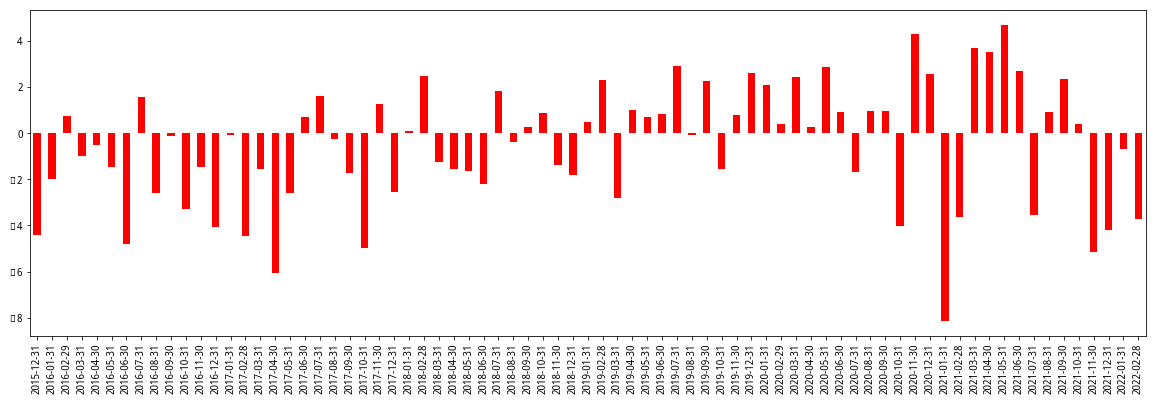

In [7]:
# t 检验，IC 检验
wls_params, wls_t_test, wls_p_test, ic = t_test(result, period, start_date, end_date, factor)
wls_params = pd.Series(wls_params)
wls_t_test = pd.Series(wls_t_test)
wls_p_test = pd.Series(wls_p_test)
ic = pd.Series(ic)

# t 检验结果
n = [x for x in wls_t_test.values if np.abs(x)>1.96]
print(f't值序列绝对值平均值（判断因子的显著性是否稳定）：{np.round(np.sum(np.abs(wls_t_test.values))/len(wls_t_test), 2)}')

# 样本大于30时，t的绝对值大于1.96就证明样本差异显著
print(f't值序列绝对值大于1.96的占比（判断因子的显著性是否稳定）：{np.round(len(n)/float(len(wls_t_test))*100, 2)}%')

wls_t_test.plot('bar', figsize=(20,6), color='r')

t值序列的平均P值：0.22
t值序列小于0.05的占比（判断因子的显著性是否稳定）：46.67%


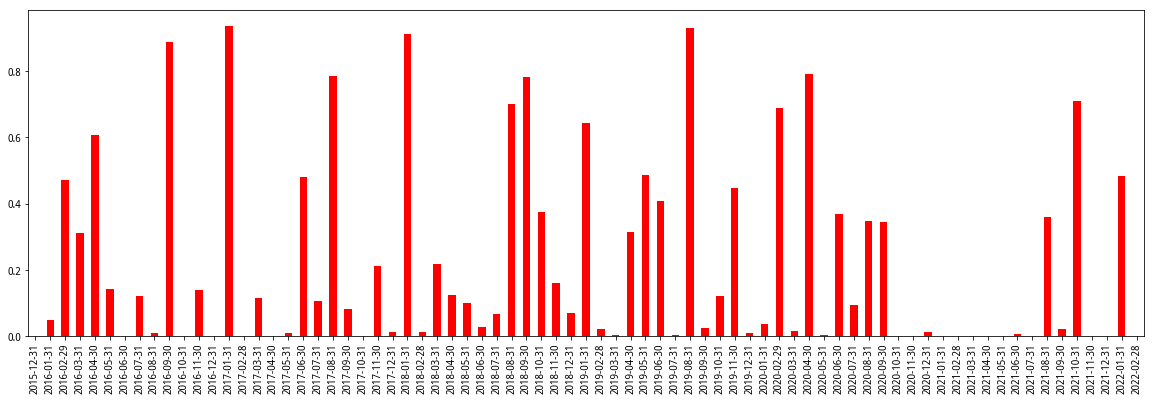

In [8]:
# t 检验结果的 P 值
n = [x for x in wls_p_test.values if x<0.05]
print(f't值序列的平均P值：{np.round(np.sum(wls_p_test.values)/len(wls_p_test), 2)}')

# 样本大于30时，t的 P 值小于0.05就证明99%置信度下显著
print(f't值序列小于0.05的占比（判断因子的显著性是否稳定）：{np.round(len(n)/float(len(wls_p_test))*100, 2)}%')

wls_p_test.plot('bar', figsize=(20,6), color='r')

IC 值序列的均值大小：-0.0249
IC 值序列的标准差：0.2146
IR 比率（IC值序列均值与标准差的比值）：-0.1158
IC 值序列大于零的占比：49.33%
IC 值序列绝对值大于0.02的占比：93.33%


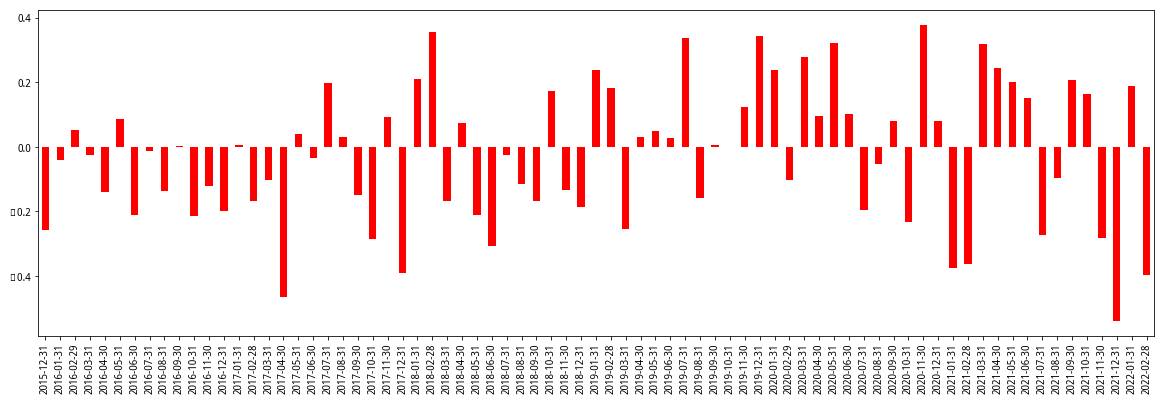

In [9]:
#IC检验结果
print(f'IC 值序列的均值大小：{np.round(ic.mean(), 4)}')
print(f'IC 值序列的标准差：{np.round(ic.std(), 4)}')
print(f'IR 比率（IC值序列均值与标准差的比值）：{np.round(ic.mean()/ic.std(), 4)}')

n_1 = [x for x in ic.values if x > 0]
print(f'IC 值序列大于零的占比：{np.round(len(n_1)/float(len(ic))*100, 2)}%')

n_2 = [x for x in ic.values if np.abs(x) > 0.02]
print(f'IC 值序列绝对值大于0.02的占比：{np.round(len(n_2)/float(len(ic))*100, 2)}%')

ic.plot('bar',figsize=(20,6), color='r')

## 回测

In [2]:
#2 设定回测策略 id ，此处注意，要换成自己的单因子策略id
start_date = '2016-01-01'
end_date = '2022-05-01'
factor = 'pe_ratio'
pa = ParameterAnalysis(algorithm_id='f69fb2a740157d66add9ff7a72351a94')

In [10]:
#3 运行回测
pa.get_backtest_data(file_name = 'results.pkl',
                     benchmark = '000300.XSHG',
                     running_max = 2,
                     start_date = start_date,
                     end_date = end_date,
                     frequency = 'day',
                     initial_cash = '1000000',
                     param_names = ['factor', 'quantile'],
                     param_values = [[factor], tuple(zip(range(0,100,10), range(10,101,10)))]
                    )

【已完成|运行中|待运行】
[0|0|10]
[0|2|8]
[0|2|8]
[0|2|8]
[0|2|8]
[0|2|8]
[0|2|8]
[0|2|8]
[0|2|8]
[0|2|8]
[0|2|8]
[0|2|8]
[0|2|8]
[0|2|8]
[0|2|8]
[0|2|8]
[0|2|8]
[0|2|8]
[0|2|8]
[0|2|8]
[0|2|8]
[0|2|8]
[1|1|8]
[1|2|7]
[1|2|7]
[1|2|7]
[1|2|7]
[1|2|7]
[1|2|7]
[1|2|7]
[2|1|7]
[2|2|6]
[2|2|6]
[2|2|6]
[2|2|6]
[2|2|6]
[2|2|6]
[2|2|6]
[2|2|6]
[2|2|6]
[2|2|6]
[2|2|6]
[2|2|6]
[2|2|6]
[2|2|6]
[2|2|6]
[2|2|6]
[2|2|6]
[2|2|6]
[2|2|6]
[2|2|6]
[2|2|6]
[2|2|6]
[3|1|6]
[3|2|5]
[3|2|5]
[3|2|5]
[3|2|5]
[3|2|5]
[3|2|5]
[3|2|5]
[3|2|5]
[4|1|5]
[4|2|4]
[4|2|4]
[4|2|4]
[4|2|4]
[4|2|4]
[4|2|4]
[4|2|4]
[4|2|4]
[4|2|4]
[4|2|4]
[4|2|4]
[4|2|4]
[5|1|4]
[5|2|3]
[5|2|3]
[5|2|3]
[5|2|3]
[5|2|3]
[5|2|3]
[5|2|3]
[6|1|3]
[6|2|2]
[6|2|2]
[6|2|2]
[6|2|2]
[6|2|2]
[6|2|2]
[6|2|2]
[6|2|2]
[6|2|2]
[6|2|2]
[6|2|2]
[6|2|2]
[6|2|2]
[6|2|2]
[6|2|2]
[6|2|2]
[6|2|2]
[6|2|2]
[6|2|2]
[6|2|2]
[6|2|2]
[6|2|2]
[7|1|2]
[7|2|1]
[7|2|1]
[7|2|1]
[7|2|1]
[7|2|1]
[7|2|1]
[8|1|1]
[8|2|0]
[8|2|0]
[8|2|0]
[8|2|0]
[8|2|0]
[8|2|0]
[8|2|0]
[8|2|0]
[8|2|0]
[

In [3]:
#4 数据读取
pa.read_backtest_data('results.pkl')

In [25]:
#5 回测参数的 Dataframe
pa.params_df

,factor,quantile
0,pe_ratio,"(0, 10)"
1,pe_ratio,"(10, 20)"
2,pe_ratio,"(20, 30)"
3,pe_ratio,"(30, 40)"
4,pe_ratio,"(40, 50)"
5,pe_ratio,"(50, 60)"
6,pe_ratio,"(60, 70)"
7,pe_ratio,"(70, 80)"
8,pe_ratio,"(80, 90)"
9,pe_ratio,"(90, 100)"


In [13]:
#6 查看回测结果指标
pa.evaluations_df

,factor,quantile,__version,algorithm_return,algorithm_volatility,alpha,annual_algo_return,annual_bm_return,avg_excess_return,avg_position_days,avg_trade_return,benchmark_return,benchmark_volatility,beta,day_win_ratio,excess_return,excess_return_max_drawdown,excess_return_max_drawdown_period,excess_return_sharpe,information,lose_count,max_drawdown,max_drawdown_period,max_leverage,period_label,profit_loss_ratio,sharpe,sortino,trading_days,treasury_return,turnover_rate,win_count,win_ratio
0,pe_ratio,"(0, 10)",101,0.0522478,0.194198,-0.00889318,0.00831274,0.0120465,1.07938e-05,NaN,NaN,0.0764485,0.198802,0.815428,NaN,-0.022482,0.359744,"[2019-03-08, 2021-02-10]",-0.385715,-0.0330278,NaN,0.291682,"[2018-01-26, 2018-10-18]",0,2022-04,NaN,-0.16317,-0.23038,1538,0.252822,NaN,NaN,NaN
1,pe_ratio,"(10, 20)",101,0.338625,0.200667,0.031815,0.0485479,0.0120465,0.000169709,313.371,0.0635757,0.0764485,0.198802,0.832352,0.479194,0.243557,0.402076,"[2018-12-27, 2021-02-10]",-0.0331954,0.308529,304,0.266442,"[2018-02-05, 2018-10-18]",0,2022-04,1.4942,0.0425972,0.0624491,1538,0.252822,0.0088789,442,0.592493
2,pe_ratio,"(20, 30)",101,0.114352,0.209619,0.00414087,0.0177555,0.0120465,4.02614e-05,NaN,NaN,0.0764485,0.198802,0.943902,NaN,0.035212,0.32035,"[2017-04-21, 2021-02-10]",-0.364178,0.0606786,NaN,0.38383,"[2018-01-26, 2019-01-03]",0,2022-04,NaN,-0.106119,-0.147347,1538,0.252822,NaN,NaN,NaN
3,pe_ratio,"(30, 40)",101,-0.0789627,0.212275,-0.0261075,-0.0132814,0.0120465,-8.58546e-05,186.227,0.0250655,0.0764485,0.198802,0.97211,0.487646,-0.144374,0.331551,"[2017-05-08, 2021-02-10]",-0.737768,-0.287837,447,0.367102,"[2018-01-26, 2018-10-18]",0,2022-04,1.11456,-0.251002,-0.354575,1538,0.252822,0.0165204,514,0.53486
4,pe_ratio,"(40, 50)",101,-0.365357,0.214091,-0.08364,-0.0712444,0.0120465,-0.000328828,167.526,0.00763244,0.0764485,0.198802,0.987511,0.477243,-0.410429,0.486235,"[2016-07-28, 2021-07-21]",-1.42879,-0.974863,491,0.426106,"[2016-01-04, 2020-03-23]",0,2022-04,0.835118,-0.519613,-0.717976,1538,0.252822,0.0171983,433,0.468615
5,pe_ratio,"(50, 60)",101,-0.236047,0.218478,-0.0548518,-0.0428221,0.0120465,-0.000206579,NaN,NaN,0.0764485,0.198802,1.0006,NaN,-0.290302,0.318476,"[2016-08-03, 2022-04-28]",-1.04163,-0.607304,NaN,0.419093,"[2017-10-13, 2018-10-18]",0,2022-04,NaN,-0.379087,-0.525514,1538,0.252822,NaN,NaN,NaN
6,pe_ratio,"(60, 70)",101,-0.148678,0.219709,-0.0377535,-0.0258252,0.0120465,-0.000135695,NaN,NaN,0.0764485,0.198802,1.00423,NaN,-0.209138,0.310833,"[2016-02-17, 2021-02-05]",-0.843417,-0.412835,NaN,0.417666,"[2017-11-13, 2018-10-18]",0,2022-04,NaN,-0.299602,-0.429561,1538,0.252822,NaN,NaN,NaN
7,pe_ratio,"(70, 80)",101,-0.210817,0.224554,-0.0492921,-0.0377534,0.0120465,-0.000182858,NaN,NaN,0.0764485,0.198802,1.01817,NaN,-0.266864,0.395634,"[2016-07-20, 2019-01-31]",-0.916267,-0.511847,NaN,0.476066,"[2016-01-04, 2019-01-03]",0,2022-04,NaN,-0.346257,-0.493928,1538,0.252822,NaN,NaN,NaN
8,pe_ratio,"(80, 90)",101,-0.394411,0.239628,-0.0889551,-0.0782922,0.0120465,-0.000345774,NaN,NaN,0.0764485,0.198802,1.0495,NaN,-0.43742,0.473742,"[2016-01-04, 2019-11-04]",-1.09061,-0.763867,NaN,0.542096,"[2016-01-04, 2019-01-03]",0,2022-04,NaN,-0.49365,-0.68186,1538,0.252822,NaN,NaN,NaN
9,pe_ratio,"(90, 100)",101,0.172673,0.261548,0.0172432,0.0262298,0.0120465,9.64283e-05,240.169,0.150343,0.0764485,0.198802,1.10947,0.504551,0.0893904,0.402607,"[2016-01-04, 2018-02-06]",-0.182106,0.0997129,263,0.473023,"[2016-01-04, 2018-10-18]",0,2022-04,1.31301,-0.052649,-0.074718,1538,0.252822,0.00737959,354,0.573744


,1分位,2分位,3分位,4分位,5分位,6分位,7分位,8分位,9分位,10分位,benchmark
0,-0.068346,-0.070756,-0.080711,-0.084159,-0.080837,-0.081285,-0.078542,-0.076566,-0.085610,-0.099154,-0.070206
1,-0.059830,-0.058576,-0.078466,-0.086445,-0.073022,-0.077957,-0.078413,-0.069998,-0.102842,-0.110725,-0.067604
2,-0.043843,-0.016581,-0.054638,-0.068726,-0.056515,-0.052266,-0.054029,-0.048721,-0.080467,-0.083817,-0.051246
3,-0.108018,-0.087430,-0.130642,-0.144213,-0.132914,-0.129376,-0.132275,-0.130645,-0.160831,-0.171788,-0.117027
4,-0.085326,-0.045301,-0.101418,-0.123070,-0.116344,-0.100600,-0.101628,-0.105688,-0.142682,-0.159387,-0.099021


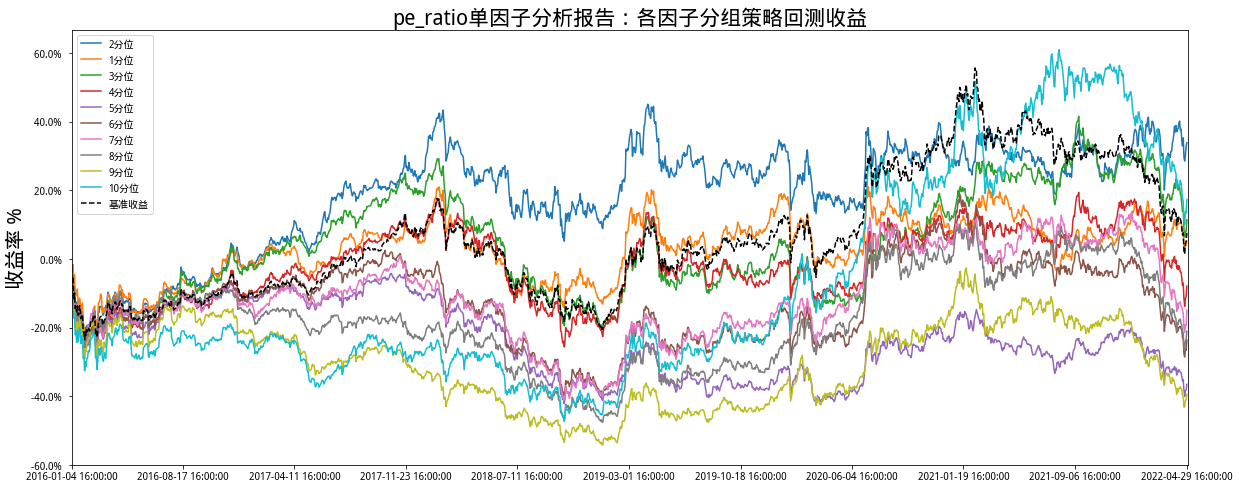

In [4]:
#7 获取10组回报率数据，同时绘制回报率折线图    
returns_data, benchmark_data = pa.plot_returns()

#获取benchmark收益率，并与1-10组合并
returns_data = pd.concat([returns_data, benchmark_data], axis=1)
returns_data.head()

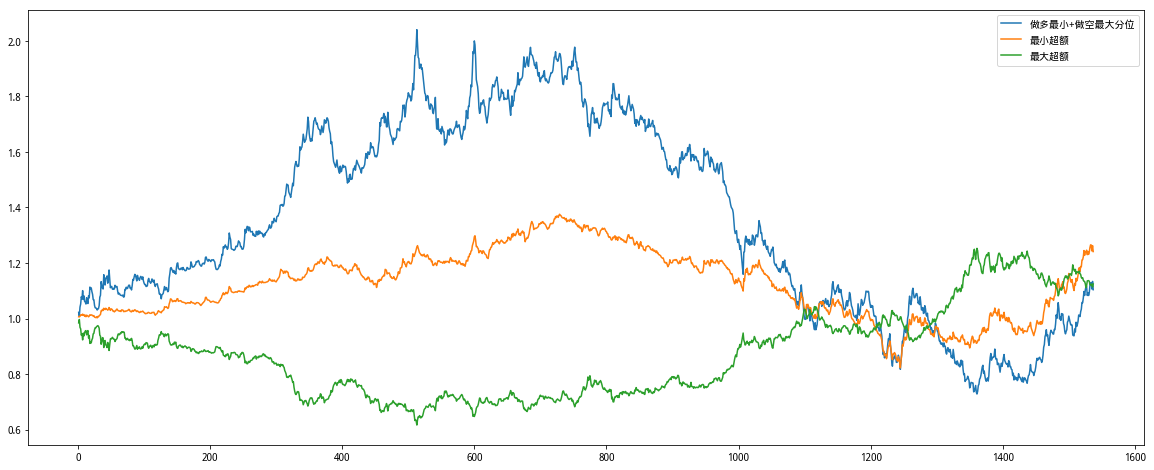

In [5]:
#绘制第一组的净值除以第十组和benchmark组的净值，检验做多第一组做空第十组和仅仅做多第一组的效应，以此来检验因子是否具有很好的选股功能
returns_data['group1_temp'] = 1+returns_data['1分位']
returns_data['group10_temp'] = 1+returns_data['10分位']
returns_data['benchmark_temp'] = 1+returns_data['benchmark']
returns_data['group1_temp_lag'] = returns_data['group1_temp'].shift(1)
returns_data['group10_temp_lag'] = returns_data['group10_temp'].shift(1)
returns_data['benchmark_temp_lag'] = returns_data['benchmark_temp'].shift(1)
returns_data = returns_data.dropna()
returns_data['group1_day_return'] = returns_data['group1_temp']/returns_data['group1_temp_lag']
returns_data['group10_day_return'] = returns_data['group10_temp']/returns_data['group10_temp_lag']
returns_data['benchmark_day_return'] = returns_data['benchmark_temp']/returns_data['benchmark_temp_lag']
returns_data['group1_value'] = returns_data['group1_day_return'].cumprod()
returns_data['group10_value'] = returns_data['group10_day_return'].cumprod()
returns_data['benchmark_value'] = returns_data['benchmark_day_return'].cumprod()
returns_data['做多最小+做空最大分位'] = returns_data['group1_value']/returns_data['group10_value']
returns_data['最小超额'] = returns_data['group1_value']/returns_data['benchmark_value']
returns_data['最大超额'] = returns_data['group10_value']/returns_data['benchmark_value']

#绘制第一组除以第十组的净值曲线
#曲线一直上升，说明做多第一组做空第十组有效
#绘制第一组除以benchmark组的净值曲线
#曲线一直上升，说明做多第一组可以带来超额收益
#绘制第十组除以benchmark组的净值曲线
#曲线一直下降，说明做空第十组也可以带来超额收益（注意，做空第十组带来的超额收益的无效的，因为股票不可能做空）
#我们期望的是超额收益最好全部来自做多第一组
plt.figure(figsize=(20,8))
returns_data['做多最小+做空最大分位'].plot()
returns_data['最小超额'].plot()
returns_data['最大超额'].plot()
plt.legend()

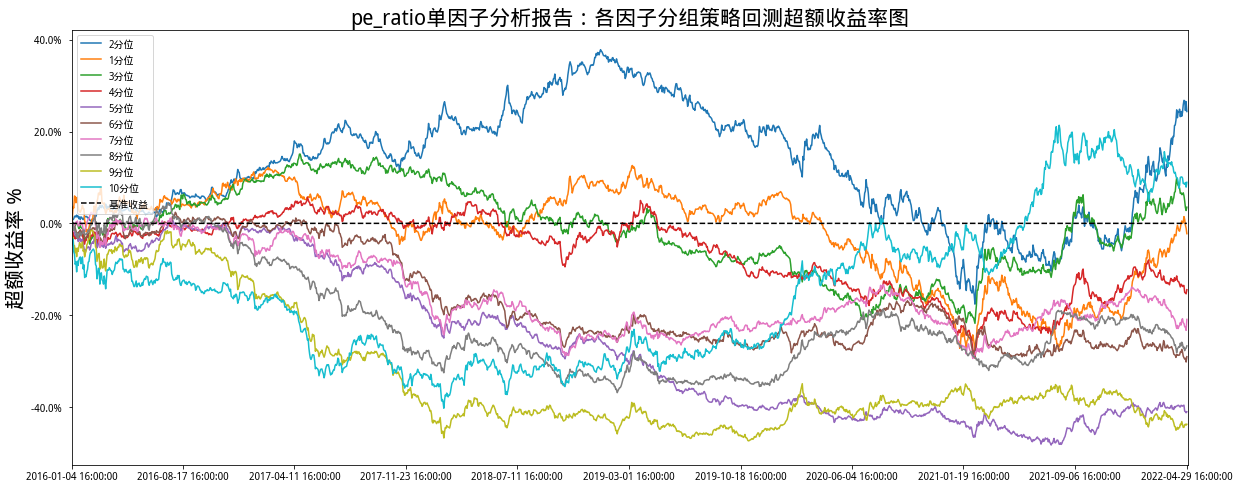

In [5]:
#8 超额收益率图
pa.plot_excess_returns()

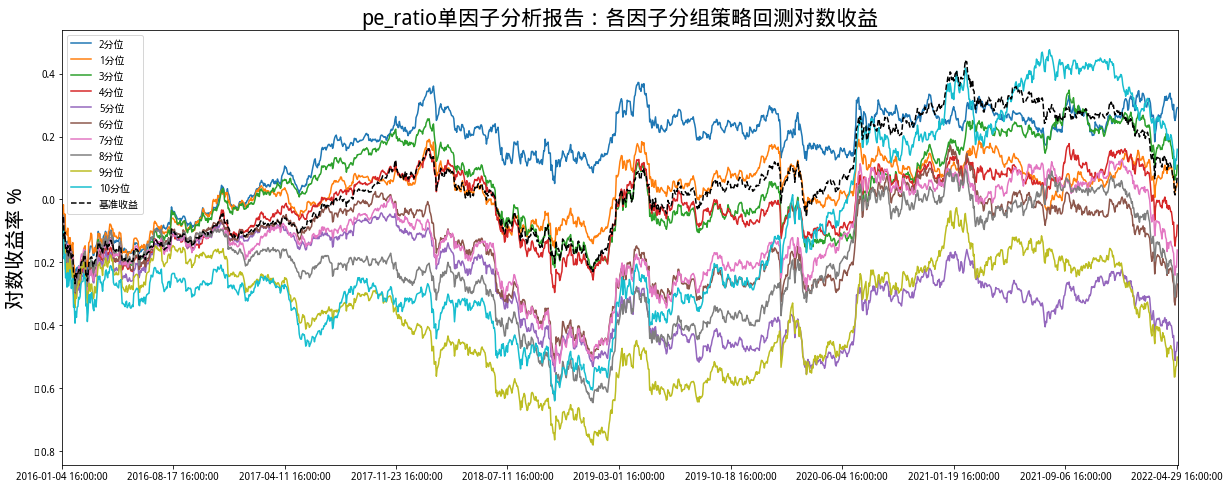

In [6]:
#9 log回报率图    
pa.plot_log_returns()

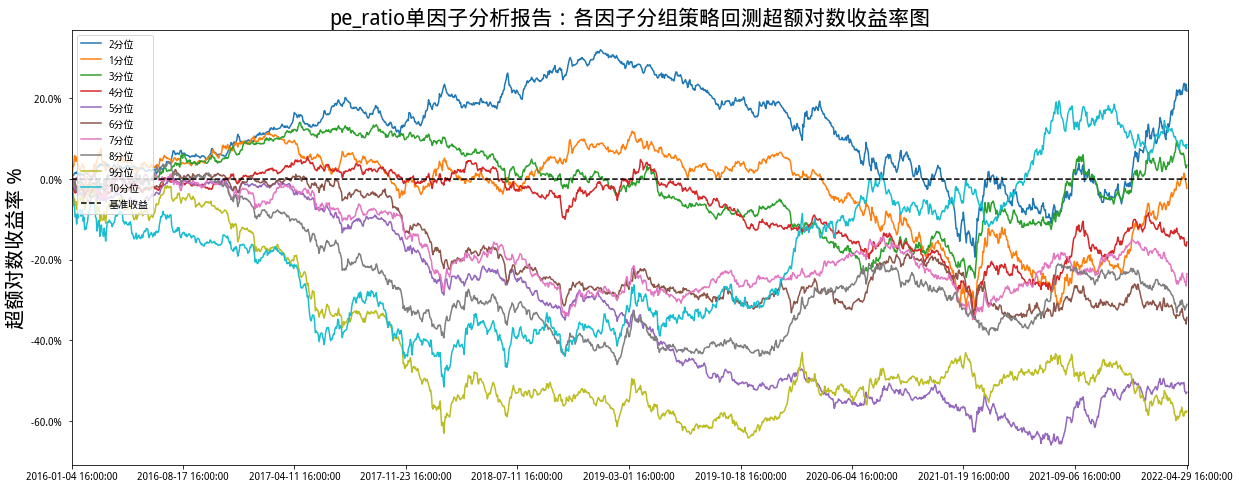

In [7]:
#10 超额收益率的 log 图
pa.plot_log_excess_returns()

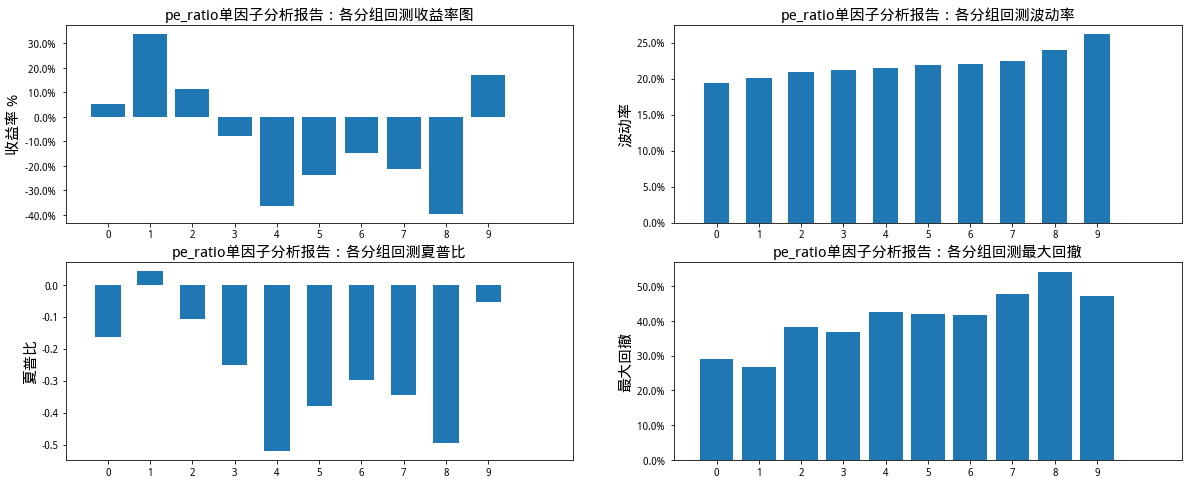

In [8]:
#11 回测的4个主要指标，包括总回报率、最大回撤夏普率和波动
pa.get_eval4_bar()

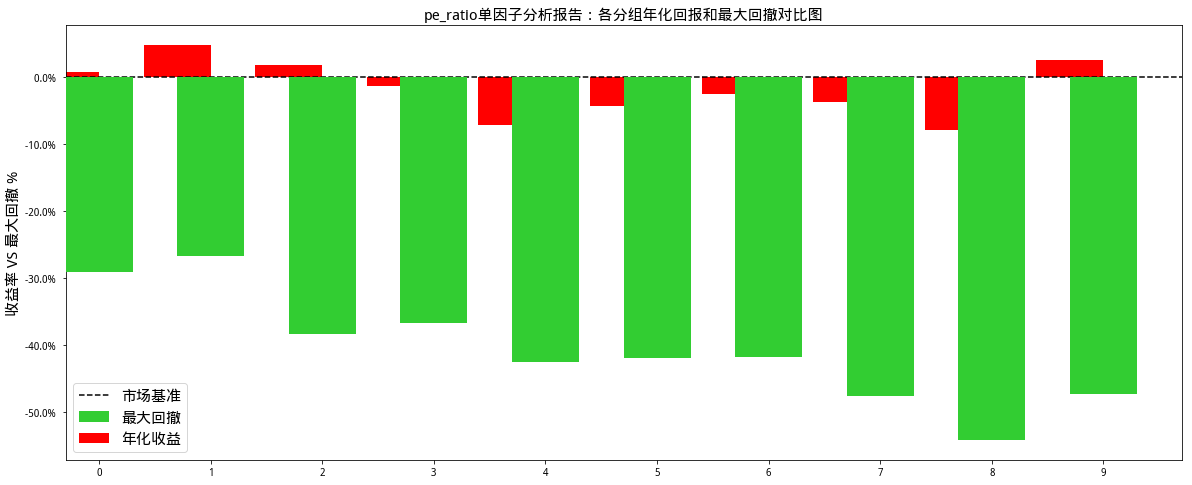

In [9]:
#12 年化回报和最大回撤，正负双色显示
pa.get_eval()

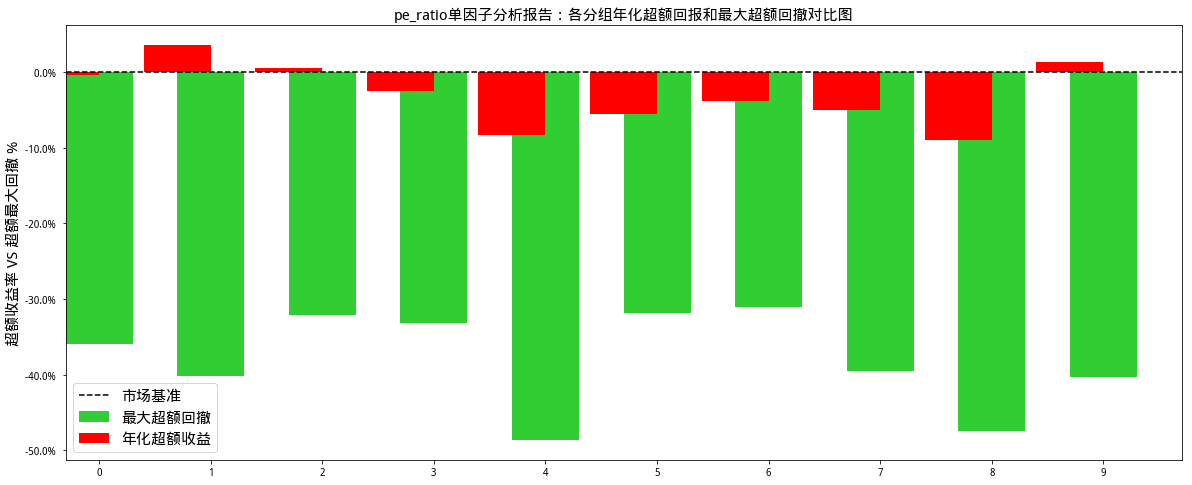

In [10]:
#13 超额收益的年化回报和最大回撤
pa.get_excess_eval()

In [22]:
returns_data.head()

,1分位,2分位,3分位,4分位,5分位,6分位,7分位,8分位,9分位,10分位,benchmark,group1_temp,group10_temp,benchmark_temp,group1_temp_lag,group10_temp_lag,benchmark_temp_lag,group1_day_return,group10_day_return,benchmark_day_return,group1_value,group10_value,benchmark_value,做多最小+做空最大分位,最小超额,最大超额
1,-0.059830,-0.058576,-0.078466,-0.086445,-0.073022,-0.077957,-0.078413,-0.069998,-0.102842,-0.110725,-0.067604,0.940170,0.889275,0.932396,0.931654,0.900846,0.929794,1.009141,0.987155,1.002799,1.009141,0.987155,1.002799,1.022271,1.006324,0.984400
2,-0.043843,-0.016581,-0.054638,-0.068726,-0.056515,-0.052266,-0.054029,-0.048721,-0.080467,-0.083817,-0.051246,0.956157,0.916183,0.948754,0.940170,0.889275,0.932396,1.017004,1.030258,1.017544,1.026301,1.017025,1.020392,1.009120,1.005791,0.996701
3,-0.108018,-0.087430,-0.130642,-0.144213,-0.132914,-0.129376,-0.132275,-0.130645,-0.160831,-0.171788,-0.117027,0.891982,0.828212,0.882973,0.956157,0.916183,0.948754,0.932882,0.903981,0.930666,0.957418,0.919371,0.949644,1.041383,1.008186,0.968123
4,-0.085326,-0.045301,-0.101418,-0.123070,-0.116344,-0.100600,-0.101628,-0.105688,-0.142682,-0.159387,-0.099021,0.914674,0.840613,0.900979,0.891982,0.828212,0.882973,1.025440,1.014973,1.020392,0.981774,0.933137,0.969009,1.052122,1.013174,0.962981
5,-0.130857,-0.094637,-0.148947,-0.173309,-0.167216,-0.153399,-0.144991,-0.159883,-0.199159,-0.220694,-0.144347,0.869143,0.779306,0.855653,0.914674,0.840613,0.900979,0.950222,0.927069,0.949693,0.932903,0.865082,0.920261,1.078398,1.013738,0.940040


In [23]:
#获取前三组的资金曲线平均值减去后三组的资金曲线平均值，从数据上判断二者是否由显著差异
returns_data['cy'] = (returns_data['1分位']+returns_data['2分位']+returns_data['3分位'])/3-(returns_data['8分位']+returns_data['9分位']+returns_data['10分位'])/3

#组间差异t检验，pvalue代表组间差异等于0的概率，pvalue = 5.8*10^-244，基本就等于0，说明组间差异显著异于0
ttest_1samp(returns_data['cy'],0)

Ttest_1sampResult(statistic=70.22812988946043, pvalue=0.0)